In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from typing import Tuple, Union
from sklearn.utils.validation import check_is_fitted
from scipy.linalg import solve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

import scipy

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [8]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [9]:
def plot_logit_results(df, pred_key, ax, suptitle, grid=False, error_key=None, pred_min=0, pred_max=1, error_min=0.1, error_max=0.2):
    ax.set_title(suptitle)
    #sn.set_theme(style="whitegrid")

    cmap = red_blue_cmap()
    if grid:
        ax.hist2d(x= df["x1"], y=df["x2"], weights=df[pred_key], 
                bins = 100,
                #norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                cmap=cmap)
    else:
        if (error_key == None):
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                            palette=cmap, legend=False)
        else:
            sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                        #hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        size=error_key, #size_norm = (0.1, 0.2), sizes=(10, 200),
                            palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.set_aspect('equal', adjustable='box')

    return ax

In [10]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"

load_values = False
save_values = False

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nxMC_200_nr1MC_100"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

X_test = test_data[[x1_key, x2_key]]
Y_test = test_data["class"]

X_grid = grid_data[[x1_key, x2_key]]

### Uncertainties in Gaussian Processes

In [11]:


#https://stackoverflow.com/questions/67818319/how-to-output-mean-and-stdv-of-gaussian-process-classifier-in-sklearn
class LatentGPC(GaussianProcessClassifier):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def predict_a(
        self, X: np.ndarray, return_std: bool = False
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """
        Return estimates of the latent function for X.
        
        Notes:
        ------
        - For binary classification (n_classes = 2), the output shape is
        (n_samples,).
        - For multi-class classification, the output shape is (n_samples,
        n_classes) when multi_class="one_vs_rest", and is shaped (n_samples,
        n_classes*(n_classes - 1)/2) when multi_class="one_vs_one". In other
        terms, There are as many columns as trained Binary GPC sub-models.
        - The number of classes (n_classes) is determined by the number of
        unique target values in the training data.
        """
        check_is_fitted(self)

        if self.n_classes_ > 2:  # Multi-class case
            f_stars = []
            std_f_stars = []
            for estimator, kernel in zip(self.base_estimator_.estimators_, self.kernel_.kernels):
                result = self._binary_predict_a(estimator, kernel, X, return_std)
                if not return_std:
                    f_stars.append(result)
                else:
                    f_stars.append(result[0])
                    std_f_stars.append(result[1])

            if not return_std:
                return np.array(f_stars).T

            return np.array(f_stars).T, np.array(std_f_stars).T
        else:  # Binary case
            return self._binary_predict_a(self.base_estimator_, self.kernel_, X, return_std)

    @staticmethod
    def _binary_predict_a(estimator, kernel, X, return_std):
        """ Return mean and std of the latent function estimates for X. """
        check_is_fitted(estimator)

        # Based on Algorithm 3.2 of GPML
        K_star = kernel(estimator.X_train_, X)  # K_star = k(x_star)
        f_star = K_star.T.dot(estimator.y_train_ - estimator.pi_)  # Line 4
        if not return_std:
            return f_star

        v = solve(estimator.L_, estimator.W_sr_[:, np.newaxis] * K_star)  # Line 5
        # Line 6 (compute np.diag(v.T.dot(v)) via einsum)
        var_f_star = kernel.diag(X) - np.einsum("ij,ij->j", v, v)

        return f_star, np.sqrt(var_f_star)
    

def predictive_prob(mf, stdf):
    """Approximation to int sigma(f) N(f|mf,stdf**2) df
    where sigma is the logistic function and N is a Gaussian
    By David JC MacKay, 1992"""
    f_transform = mf/np.sqrt(1.0 + np.pi * stdf**2 / 8.0)
    
    return (1/(1+np.exp(-f_transform)))



In [12]:
# https://www.geeksforgeeks.org/gaussian-process-classification-gpc-on-iris-dataset/
n_data = [5000, 5000, 5000, 5000]
#n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
#n_data =[70]

max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.5
        
grid_latent_dfs = [0]*(len(n_data))
test_latent_dfs = [0]*(len(n_data))
ls = 0.2  #Length scale
ov = 0.5

if load_values==False:
    for i in tqdm(range(len(n_data))):
        grid_latent_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_latent_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        X_train = train_data[[x1_key, x2_key]][0:n_data[i]]
        Y_train = train_data["class"][0:n_data[i]]
        
        kernel = ov * RBF(length_scale=ls)  # RBF kernel with default parameters
        gp = LatentGPC(kernel=kernel)

        print(len(X_train))
        gp.fit(X_train, Y_train)
        test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_test, return_std=True)
        test_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Logit_blue"]))
        test_latent_dfs[i]["Prediction"] = gp.predict(X_test)

        grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"] = gp.predict_a(X_grid, return_std=True)
        grid_latent_dfs[i]["Sigmoid_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Logit_blue"]))
        grid_latent_dfs[i]["Prediction"] = gp.predict(X_grid)

        test_latent_dfs[i]["Est_prob_blue"] = predictive_prob(test_latent_dfs[i]["Logit_blue"], test_latent_dfs[i]["Std_logit_blue"])
        grid_latent_dfs[i]["Est_prob_blue"] = predictive_prob(grid_latent_dfs[i]["Logit_blue"], grid_latent_dfs[i]["Std_logit_blue"])
        test_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-test_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
        grid_latent_dfs[i]["Sigmoid_std_logit_blue"] = 1/(1+np.exp(-grid_latent_dfs[i]["Std_logit_blue"]))-0.5 #Scales like the mean but is only positive
        
        # Save prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                    os.mkdir(f"predictions/{trainfile}")
            test_latent_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
            grid_latent_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")
        grid_latent_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_latentGP_{ov}_ls{ls}_ndata-{n_data[i]}.csv")

  0%|          | 0/4 [00:00<?, ?it/s]

5000


 25%|██▌       | 1/4 [03:47<11:23, 227.87s/it]

5000


 50%|█████     | 2/4 [07:56<08:00, 240.05s/it]

5000


 75%|███████▌  | 3/4 [12:05<04:04, 244.09s/it]

5000


100%|██████████| 4/4 [16:27<00:00, 246.96s/it]


## Not properly normalized

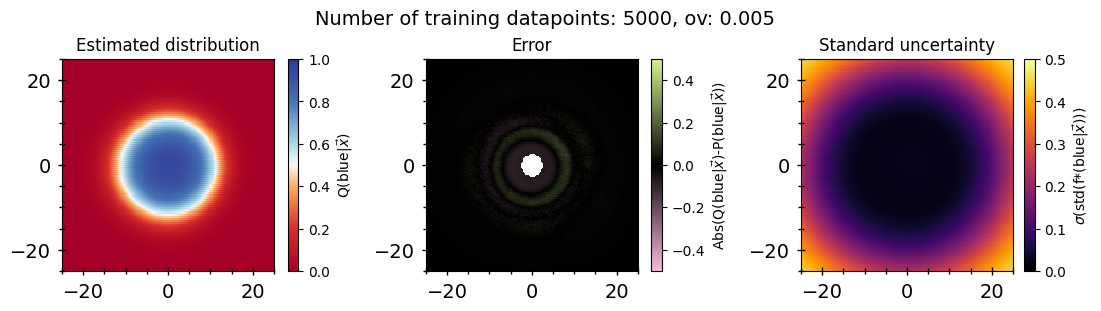

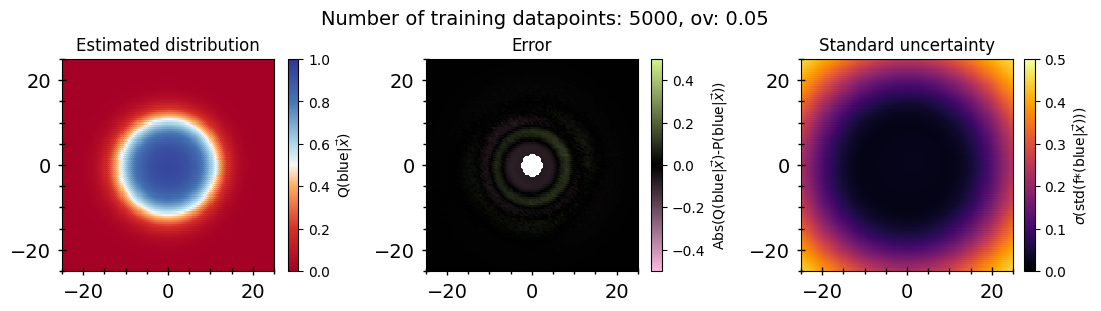

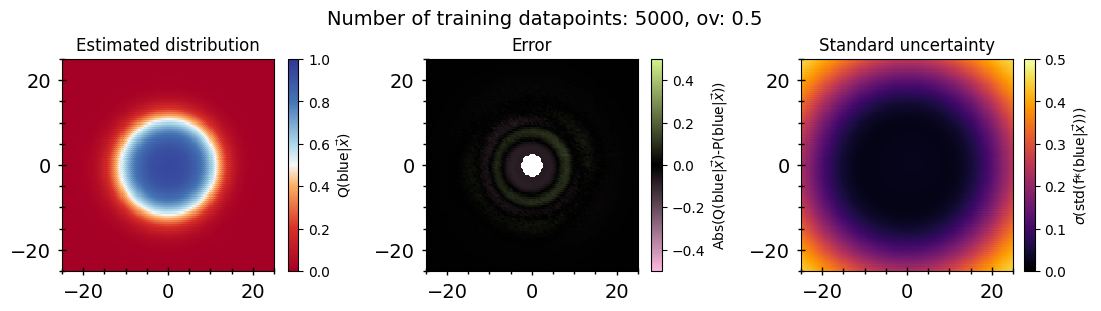

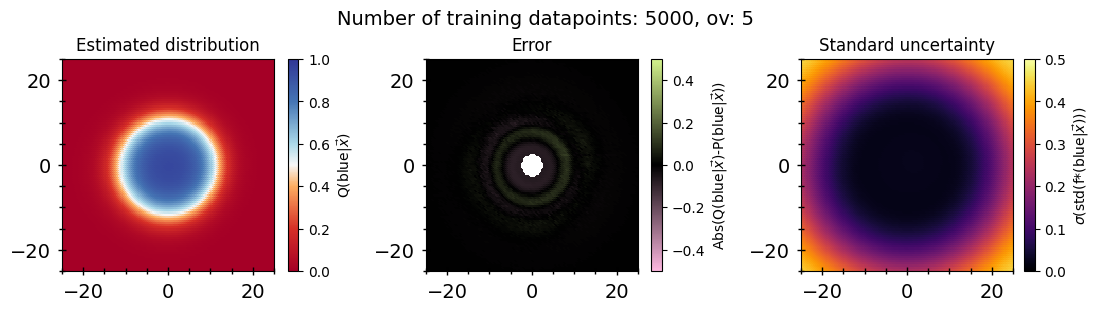

In [17]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

    axs[0] = plot_results(grid_latent_dfs[i], "Sigmoid_blue", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_latent_dfs[i], truth_data, "Sigmoid_blue", "P_blue_given_x", axs[1], r"Error", max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

    axs[2] = plot_std(grid_latent_dfs[i], "Sigmoid_std_logit_blue", axs[2], "Standard uncertainty", grid=True, max_val=max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                 label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)


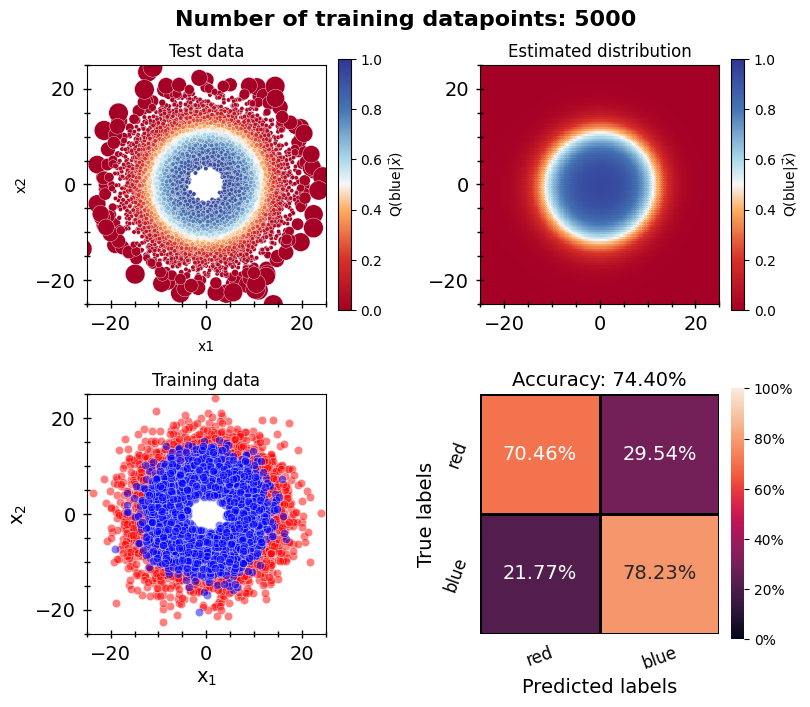

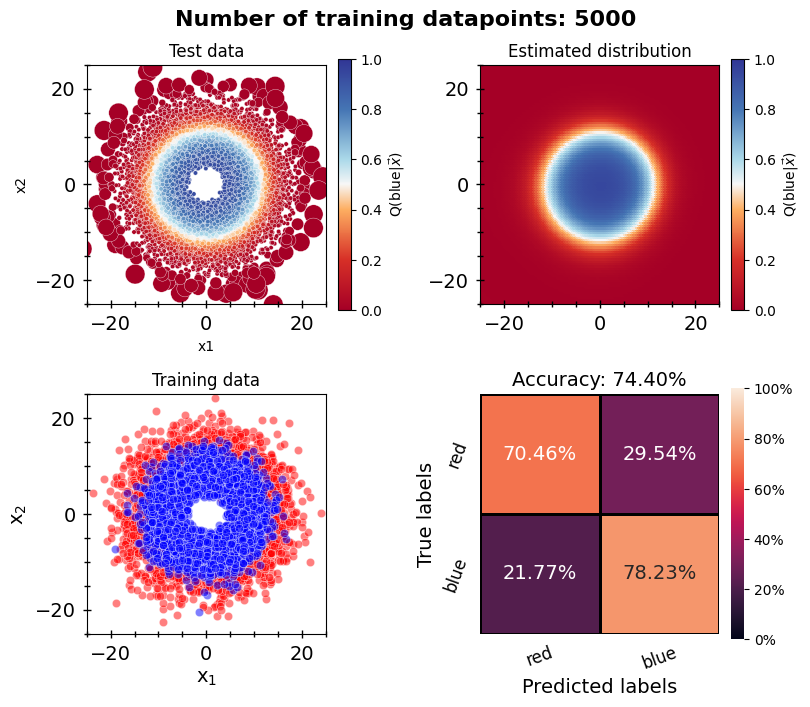

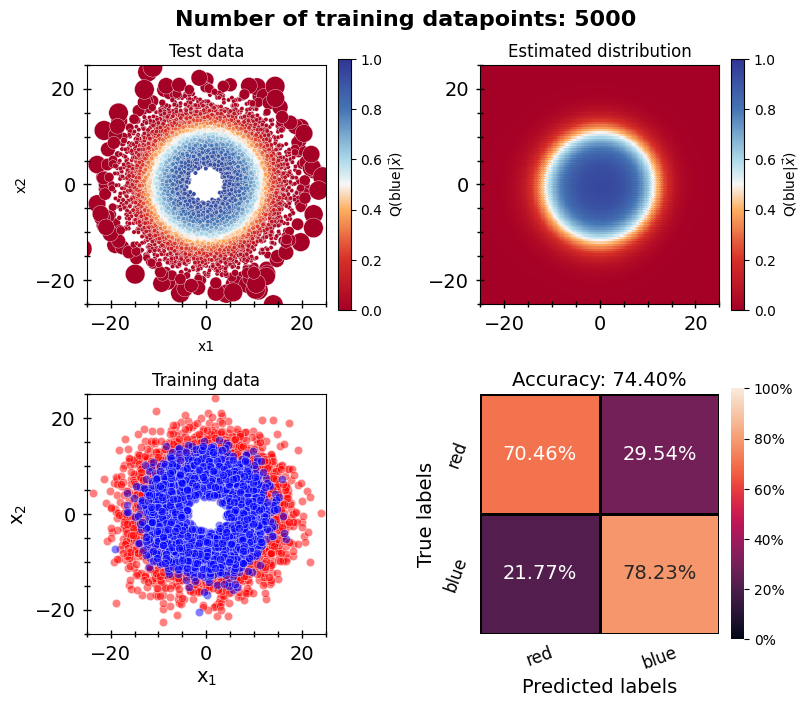

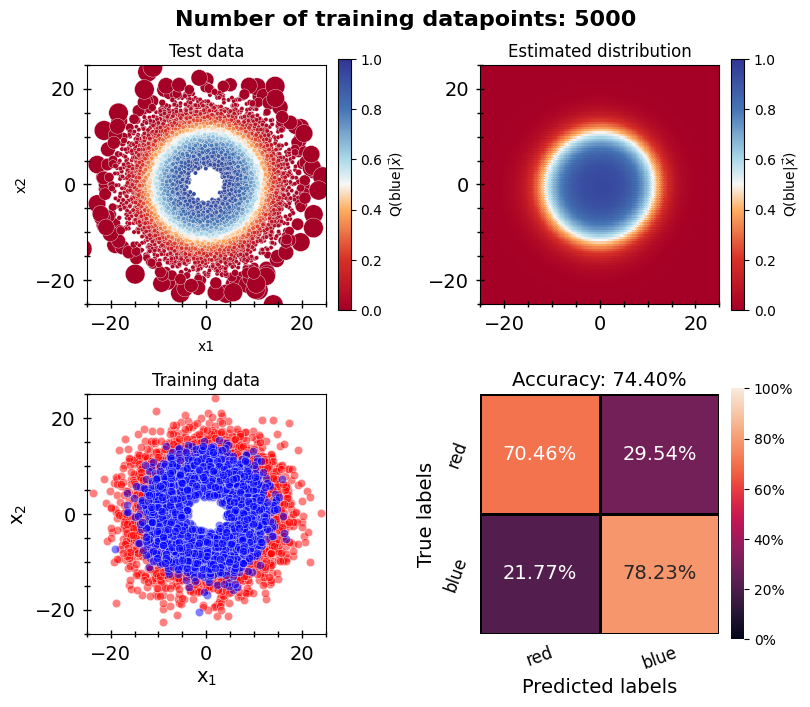

In [14]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,7), layout="constrained")
    axs[0][0] = plot_results(test_latent_dfs[i], "Est_prob_blue", axs[0][0], "Test data", error_key="Sigmoid_std_logit_blue")
    axs[0][1] = plot_results(grid_latent_dfs[i], "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True)
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")
    axs[1][1] = plot_conf_matrix(test_latent_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

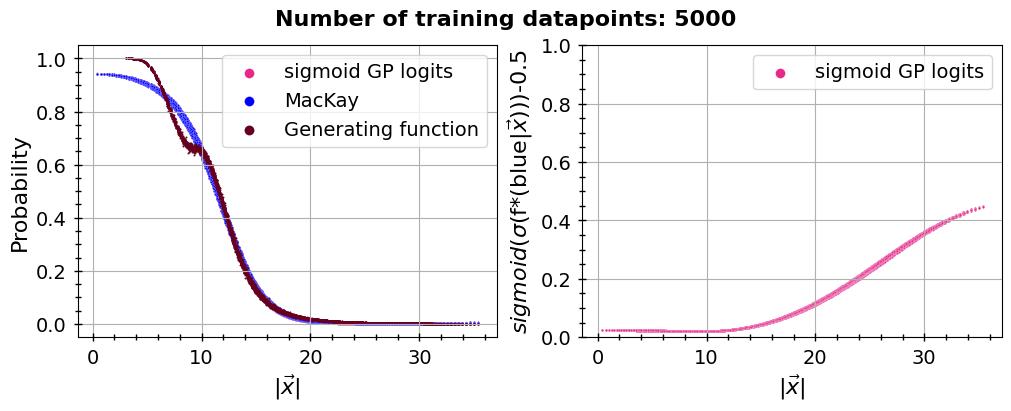

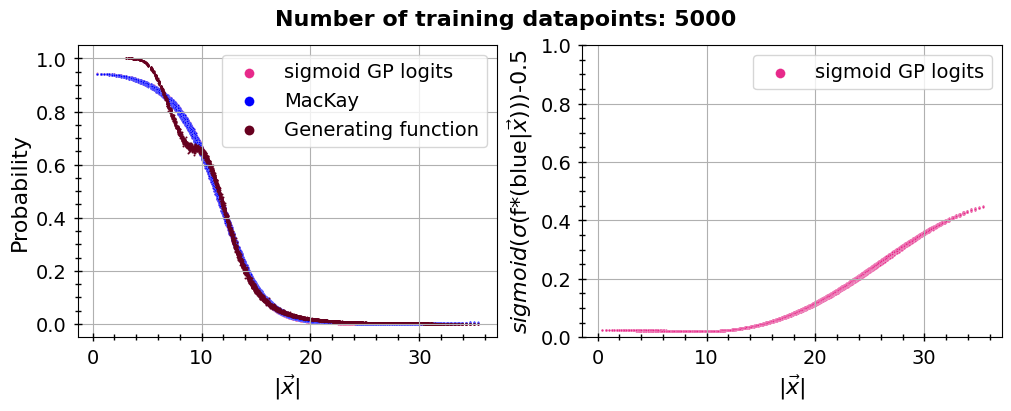

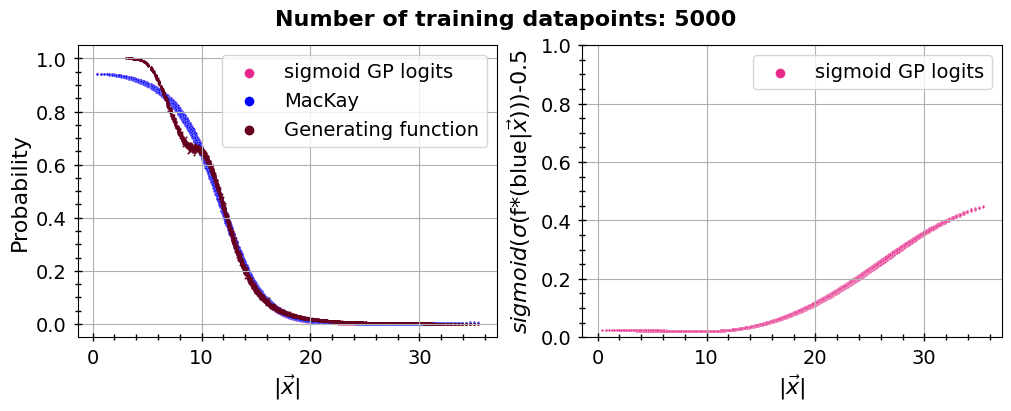

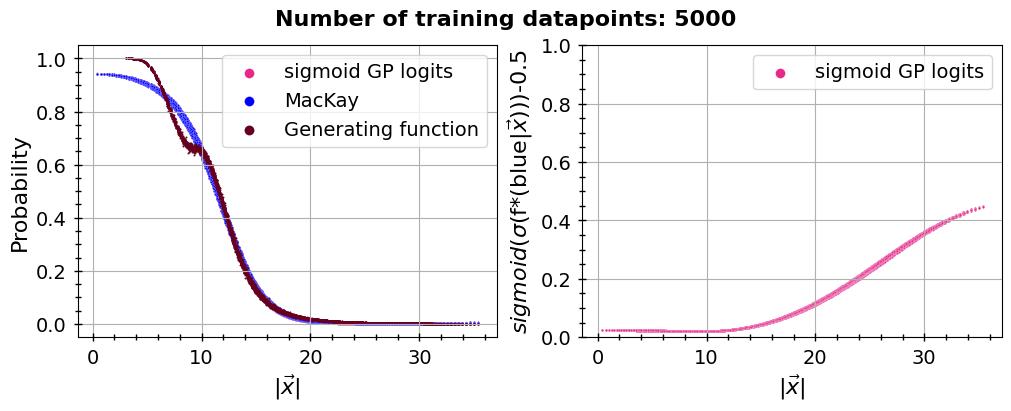

In [15]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Sigmoid_blue", s=2, ax = axs[0], label="sigmoid GP logits", color="#e7298a")
    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Est_prob_blue", s=2, ax = axs[0], label="MacKay", color="blue")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Probability", fontsize=16)

    sn.scatterplot(grid_latent_dfs[i], x="r_x", y="Sigmoid_std_logit_blue", s=2, ax = axs[1], label="sigmoid GP logits", color="#e7298a")
    axs[1].set_ylabel(r"$sigmoid(\sigma$(f*(blue|$\vec{x}$)))-0.5", fontsize=16)
    axs[1].set_ylim(0, 1)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [16]:
scores = calculate_metrics(test_latent_dfs, grid_latent_dfs, n_data, truth_data, truth_test_data, 
                           "Prediction", "Est_prob_blue", "Sigmoid_std_logit_blue")

print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0    5000  0.743974  0.821611  0.028054  0.014976  0.032047  0.023177   
1    5000  0.743974  0.821611  0.028054  0.014976  0.032047  0.023177   
2    5000  0.743974  0.821611  0.028054  0.014976  0.032047  0.023177   
3    5000  0.743974  0.821611  0.028054  0.014976  0.032047  0.023177   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.001267          0.001343  0.512027  0.031103  0.057676  0.036274  
1          0.001267          0.001343  0.512027  0.031103  0.057676  0.036274  
2          0.001267          0.001343  0.512027  0.031103  0.057676  0.036274  
3          0.001267          0.001343  0.512027  0.031103  0.057676  0.036274  
